In [1]:
import matplotlib.pyplot as plt
from src.models import *
from src.model_analysis.utils import same_output
from src.post_quant.cle import cle_for_resmlp, cle_for_resmlp_v3
from src.post_quant.bias_absorb import ba_for_resmlp
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels, get_linear_layers

org_model = resmlp_24_v3(pretrained=True).eval()
model1 = resmlp_24(pretrained=True).eval()
model2 = resmlp_24_v3(pretrained=True).eval()
# print(same_output(model1, org_model, eps=1e-5))

# model_norm = resmlp_24_norm(pretrained=False).eval()
# model_norm.load_state_dict(torch.load("771.pth")["model"])
# qmodel = q_resmlp_v3(model)

# # test CLE
# org_model = resmlp_24(pretrained=False).eval()
# org_model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
# model = resmlp_24(pretrained=False).eval()
# model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
# cle_for_resmlp(model)


c:\Users\scott\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from torchsummary import summary
summary(model1, input_size=(3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
            Linear-4             [-1, 196, 384]         147,840
            Linear-5             [-1, 384, 196]          38,612
            Linear-6             [-1, 196, 384]         147,456
          Identity-7             [-1, 196, 384]               0
          Identity-8             [-1, 196, 384]               0
            Linear-9             [-1, 196, 384]         147,840
           Linear-10            [-1, 196, 1536]         591,360
             ReLU-11            [-1, 196, 1536]               0
          Dropout-12            [-1, 196, 1536]               0
           Linear-13             [-1, 196, 384]         590,208
          Dropout-14             [-1, 1

In [67]:
l2.bias.shape

torch.Size([196])

In [4]:
import plotly.express as px
import pandas as pd

df = px.data.tips()
fig = px.violin(df, y="tip", x="smoker", color="sex", box=True, points="all",
          hover_data=df.columns)
fig.show()
display(df)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U9')) -> None

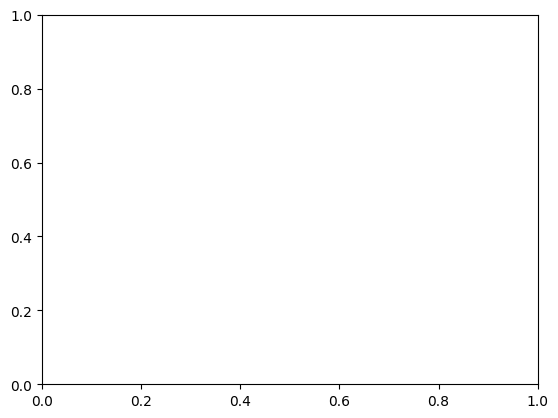

In [3]:
model_layers = []
for i in range(0, 1):
    todo_layer = model2.blocks[i]
    model_layers.append(get_linear_layers(todo_layer, specify_names=None, prefix=f"{i}-"))
# print(model_layers[0].weight.detach().numpy().flatten())

data = []
labels = []
for layer in model_layers:
    for n, m in layer:
        val = m.weight
        data.append(val.detach().numpy().flatten())
        labels.append(n)

plt.violinplot(data, labels=labels)

In [83]:
l1 = model1.blocks[0].norm1.eval()
l2 = model1.blocks[0].attn.eval()
l3 = model1.blocks[0].gamma_1.eval()

print(l1.weight.shape, l2.weight.shape, l3.weight.shape)

x = torch.randn(1, 196, 384)

# F.linear(l1.weight, l2.weight)
# l1(x)

# fuse the three linears

W1 = l1.weight * l3.weight
B1 = l1.bias.repeat(196,1)@ l3.weight + torch.inverse(l2.weight) @ l2.bias.repeat(384,1).T @ l3.weight

W2 = l2.weight
# weight = l2.weight @ l1.weight
# bias = l2.bias + F.linear(l2.weight, l1.bias)

out1 = l3(l2(l1(x).transpose(1,2)).transpose(1,2))
out2 = W2 @ (x @ W1 + B1)
torch.allclose(out1, out2, atol=1e-5)

torch.Size([384, 384]) torch.Size([196, 196]) torch.Size([384, 384])


True

l2.in_features


torch.load("fin_S24_ReLU.pth")

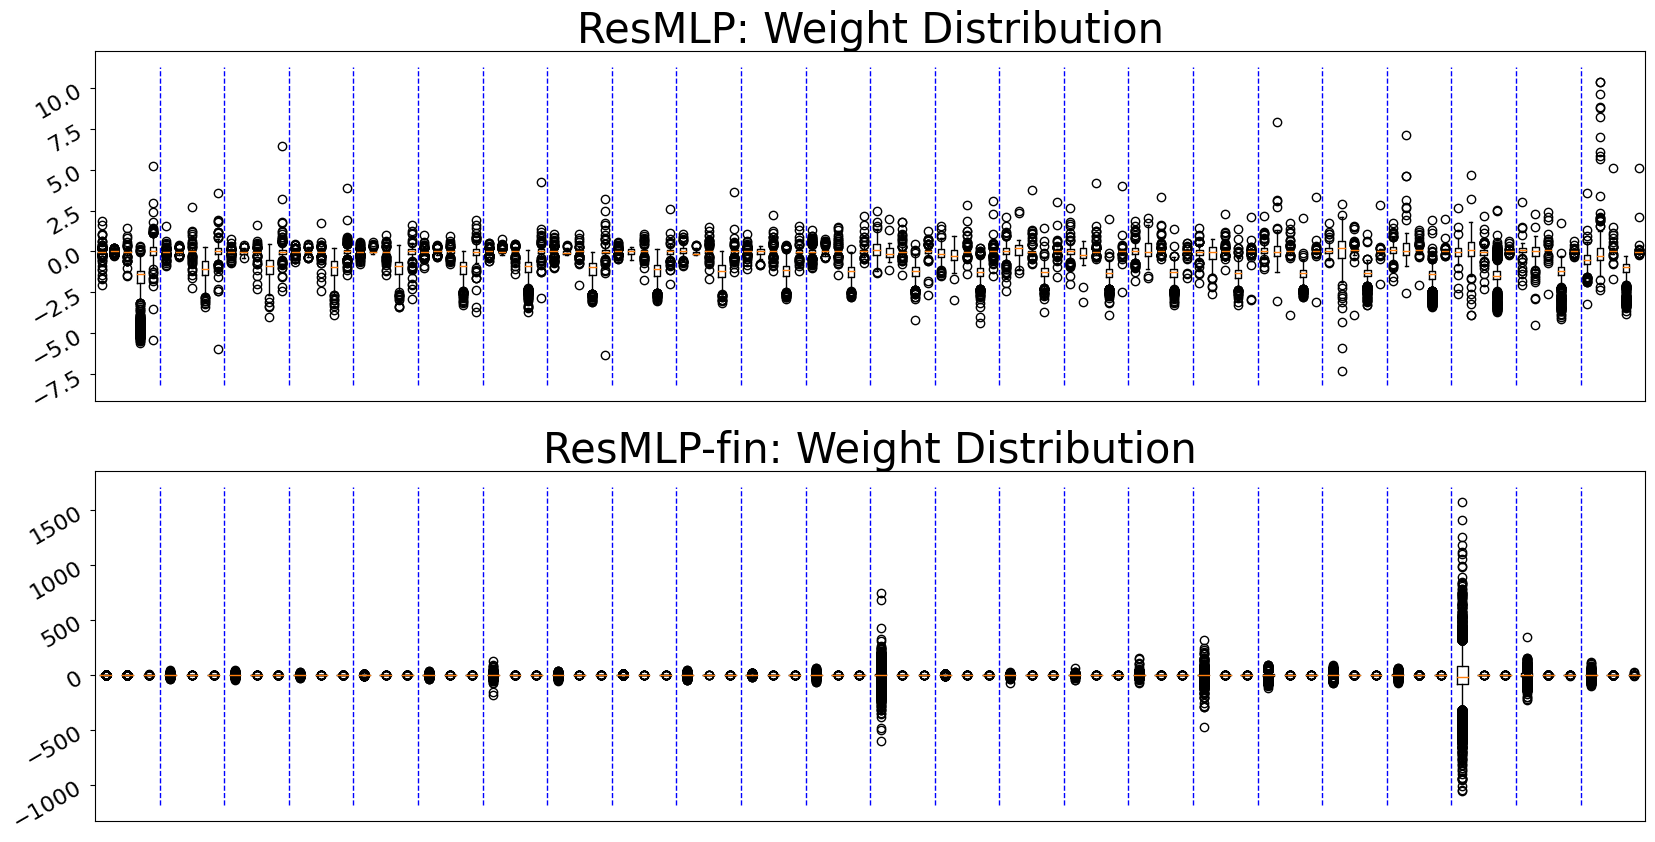

In [2]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
# model2.cpu()
layer_dist(model1, 0, 23, name="ResMLP: Weight Distribution", ax=ax[0], type="bias")

# model2.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(model2, 0, 23, name="ResMLP-fin: Weight Distribution", ax=ax[1], type="bias")

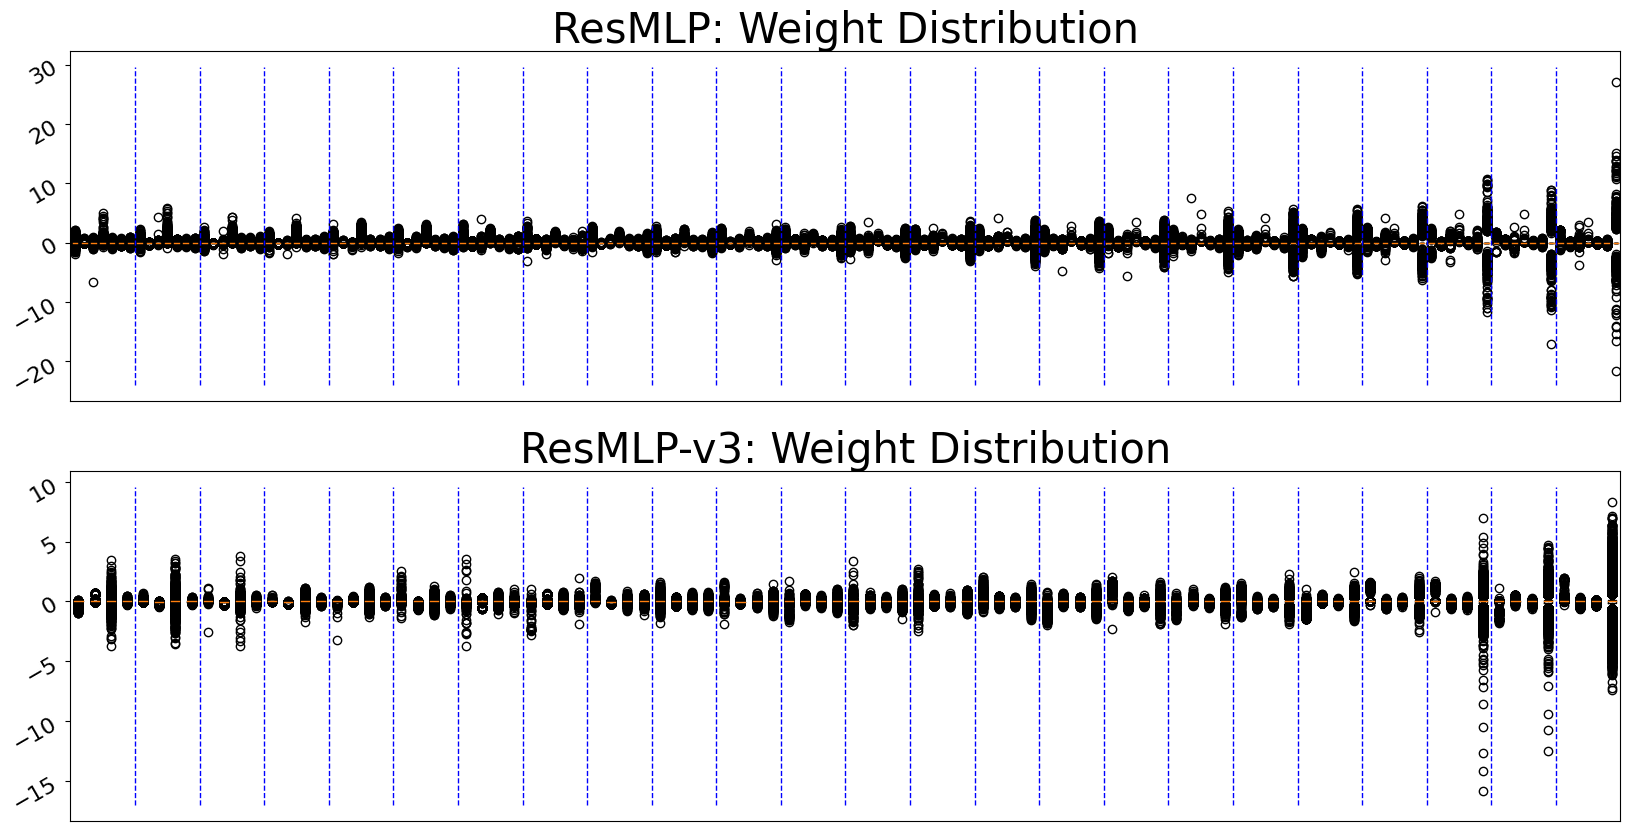

In [11]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model1.cpu()
# cle_for_resmlp(model1)
layer_dist(model1, 0, 23, name="ResMLP: Weight Distribution", ax=ax[0])

model2.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(model2, 0, 23, name="ResMLP-v3: Weight Distribution", ax=ax[1])
# layer_dist(model, 0, 23, name='ResMLP-V3: Bias Distribution', ax=ax[1], type="bias")
# cle_for_resmlp(model)
# res_
# cle_for_resmlp(model_norm)
# layer_dist(model, 0, 23, name="ResMLP-BN: Weight Distribution (before CLE)", ax=ax[1])

Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.336 ( 9.336)
Calibrate: [10/21]	Time  1.742 ( 2.388)
Calibrate: [20/21]	Time  0.193 ( 1.986)
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.337 ( 9.337)
Calibrate: [10/21]	Time  2.128 ( 2.765)
Calibrate: [20/21]	Time  0.274 ( 2.363)


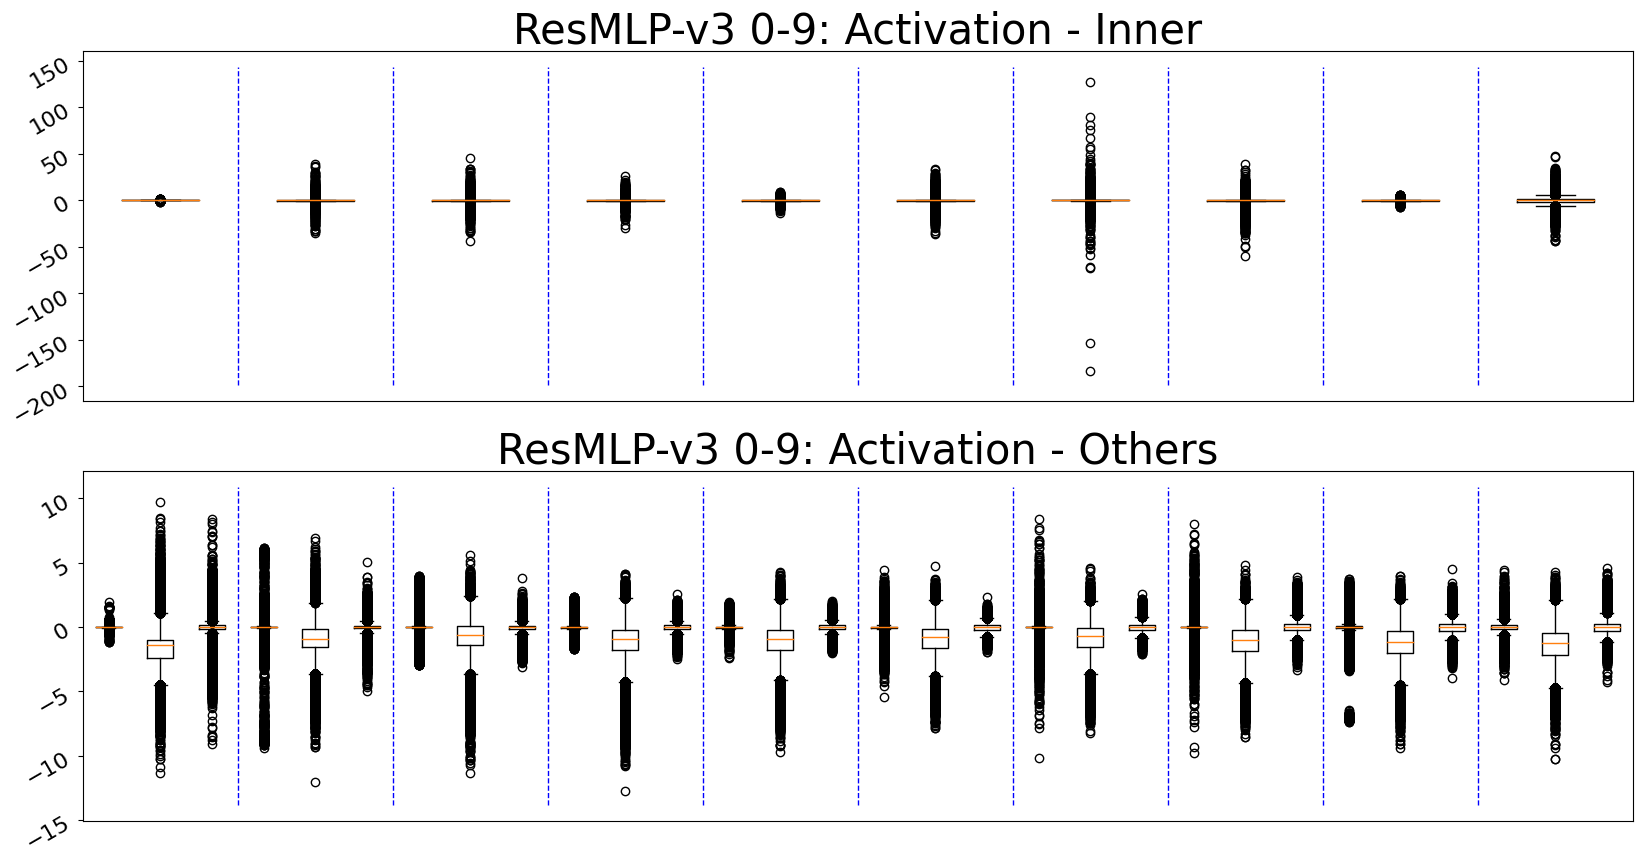

In [14]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model2.cuda()
act_dist(model2, 0, 9, name='ResMLP-v3 0-9: Activation - Inner', show_layers=["inner"], ax=ax[0], real_sim=True)

# model2.cpu()
# cle_for_resmlp_v3(model2)
model2.cuda()
act_dist(model2, 0, 9, name='ResMLP-v3 0-9: Activation - Others', show_layers=["outer", "mlp.fc1", "mlp.fc2"], ax=ax[1], real_sim=True)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model1.cuda()
act_dist(model1, 0, 23, name='ResMLP: Activation Distribution', show_layers=["inner", "mlp.fc2"], ax=ax[0], real_sim=True)

# model2.cpu()
# cle_for_resmlp_v3(model2)
model2.cuda()
act_dist(model2, 0, 23, name='ResMLP-v3: Activation Distribution', show_layers=["mlp.fc1", "mlp.fc2"], ax=ax[1], real_sim=True)

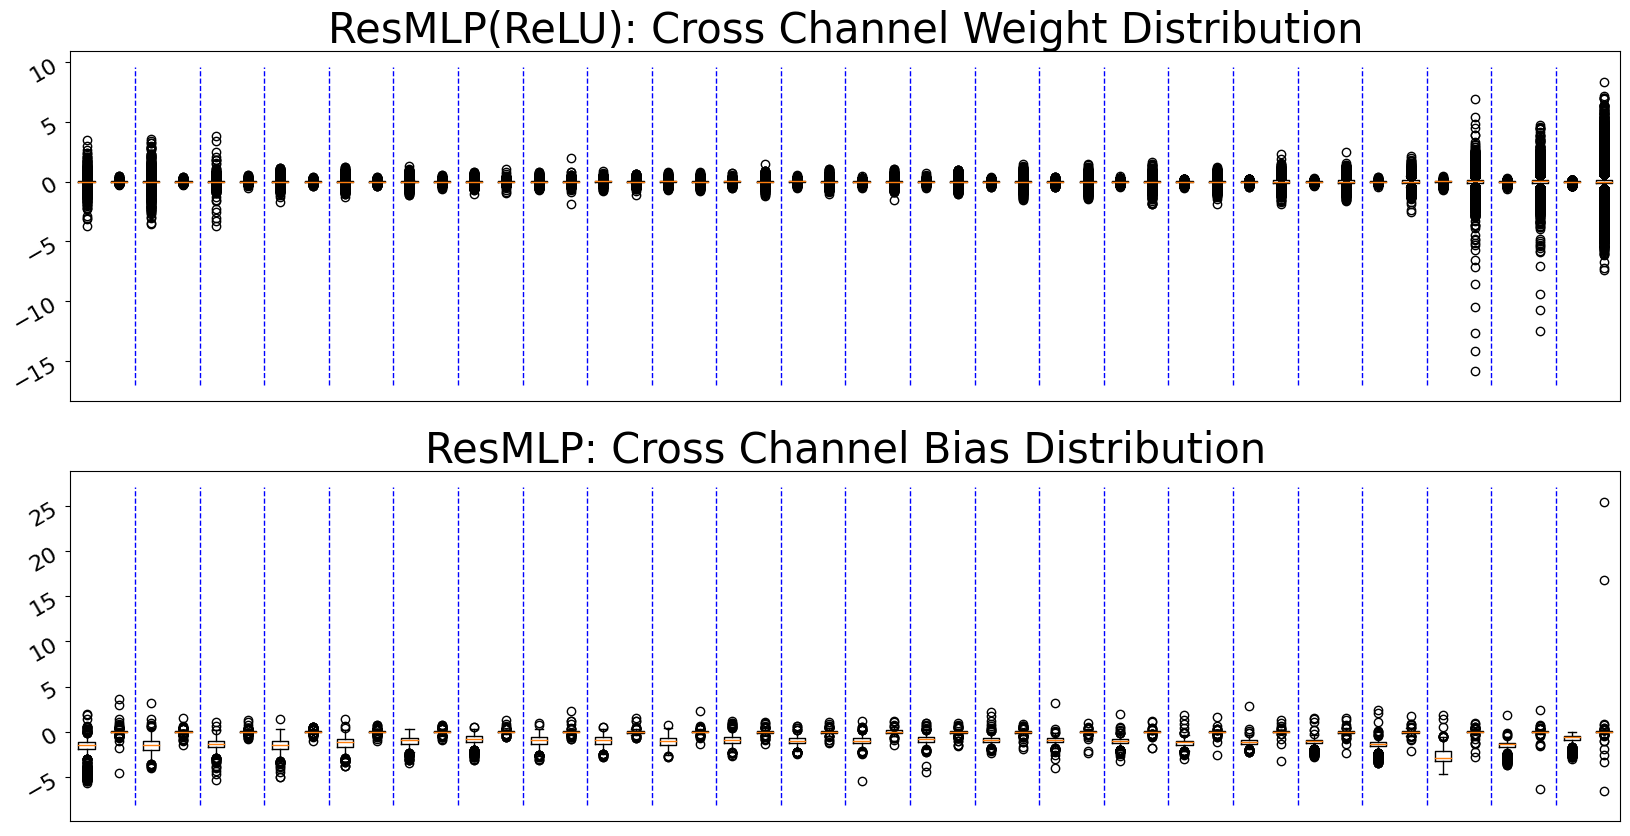

In [6]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
model.cpu()
layer_dist(model, 0, 23, name="ResMLP(ReLU): Cross Channel Weight Distribution", show_layers=["mlp.fc1", "mlp.fc2"], type="weight", ax=ax[0])
# cle_for_resmlp(model)
# res_
# cle_for_resmlp(model_norm)
layer_dist(model, 0, 23, name="ResMLP: Cross Channel Bias Distribution", show_layers=["mlp.fc1", "mlp.fc2"], type="bias", ax=ax[1])

In [ ]:
# model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# model.cuda()
# model_norm.cuda()
model.cpu()
model_norm.cpu()
labels, data = scale_plot(model, 0, 23, show_layers=["gamma_1", "gamma_2"], name='Scale of gamma_1, gamma_2', ax=ax[0])
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(labels, data)
add_value_labels(ax[0], skip_cnt=1, precision=2)

labels, data = scale_plot(model_norm, 0, 23, show_layers=["gamma_1", "gamma_2"], name='Scale of gamma_1, gamma_2', ax=ax[1])
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(labels, data)
add_value_labels(ax[1], skip_cnt=1, precision=2)



In [ ]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[0])

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer (without attn)', show_layers=["mlp.fc1", "mlp.fc2"], ax=ax[1])

In [8]:
model_norm.asda

AttributeError: 'resmlp_models' object has no attribute 'asda'

In [ ]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='Activation Distribution of Each Layer', ax=ax[0])

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[1])

In [ ]:
# ckp = torch.load("./resmlp_norm2.pth", map_location='cpu')["model"]
# modified_dict = {}
# for k, v in ckp.items():
#     # if "norm" in k:
#     #     # print(k)
#     #     if ("weight" in k) or ("bias" in k):
#     #         continue
#     modified_dict[k] = v

# _ = model_norm.load_state_dict(ckp, strict=False)

checkpoint = torch.load("./resmlp_norm2.pth", map_location='cpu')["model"]
_ = model_norm.load_state_dict(checkpoint, strict=False)

In [ ]:
model_norm = resmlp_24_norm(pretrained=True).eval()

In [ ]:
import torchsummary as summary
summary.summary(model, (3, 224, 224), device="cuda")

In [ ]:
import torchsummary as summary
summary.summary(model_norm, (3, 224, 224), device="cuda")

In [ ]:
model = resmlp_24(pretrained=True).cuda().eval()
model_norm = resmlp_24_norm(pretrained=True).cuda().eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='ResMLP-org: Activation Distribution of Each Layer', ax=ax[0], real_sim=False)
act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[1], real_sim=False)

In [ ]:
CHECKPOINT_PATH = "input8-conv-res16-act8.pth.tar"

model = resmlp_24()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])

for n, m in qmodel.named_modules():
    if isinstance(m, QLinear):
        print(n)

In [ ]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.blocks.named_modules():
    if "add_1.observer" in n:
        label_1.append(n)
        data_1.append([m.scale.item()])

ax[0].set_title('Rescale After add_1 (fp)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=2, precision=4)

label_2 = []
data_2 = []
for n, m in qmodel.named_modules():
    if "add_2.observer" in n:
        label_2.append(n)
        data_2.append(m.scale.item())

ax[1].set_title('Rescale After add_2 (fp)', size=30)
ax[1].tick_params(labelrotation=30)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(label_2, data_2)
add_value_labels(ax[1], skip_cnt=2, precision=4)

In [ ]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.blocks.named_modules():
    if "add" in n and "observer" not in n:
        label_1.append(n)
        scale = (m.res_mult[0].type(torch.double) / (2.0 ** m.res_shift[0]).type(torch.double)).type(torch.float)
        data_1.append(scale)

ax[0].set_title('Alignment for Residual Layer (int16 -> int32)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=1, precision=2)


label_2 = []
data_2 = []
for n, m in qmodel.named_modules():
    if "add" in n and "observer" not in n:
        label_2.append(n)
        scale = (m.mult[0].type(torch.double) / (2.0 ** m.shift[0]).type(torch.double)).type(torch.float)
        data_2.append(scale)

ax[1].set_title('Rescale After Residual Connection (int32 -> int8)', size=30)
ax[1].tick_params(labelrotation=30)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(label_2, data_2)
add_value_labels(ax[1], skip_cnt=2, precision=2)

In [ ]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.named_modules():
    if isinstance(m, QLinear):
        label_1.append(n)
        data_1.append(m.observer.scale.item())

ax[0].set_title('Scales for Weights Layers (fp -> int8)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=9, precision=3)


# label_2 = []
# data_2 = []
# for n, m in qmodel.named_modules():
#     if "add" in n and "observer" not in n:
#         label_2.append(n)
#         scale = (m.mult[0].type(torch.double) / (2.0 ** m.shift[0]).type(torch.double)).type(torch.float)
#         data_2.append(scale)

# ax[1].set_title('Rescale After Residual Connection (int32 -> int8)', size=30)
# ax[1].tick_params(labelrotation=30)
# for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
#     label.set_fontsize(16)
# ax[1].plot(label_2, data_2)
# add_value_labels(ax[1], skip_cnt=2, precision=2)

### Weight Scale Test

In [51]:
from torchsummary import summary
summary(org_model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
            Linear-4             [-1, 196, 384]         147,840
            Linear-5             [-1, 384, 196]          38,612
            Linear-6             [-1, 196, 384]         147,456
          Identity-7             [-1, 196, 384]               0
          Identity-8             [-1, 196, 384]               0
            Linear-9             [-1, 196, 384]         147,840
           Linear-10            [-1, 196, 1536]         591,360
             ReLU-11            [-1, 196, 1536]               0
          Dropout-12            [-1, 196, 1536]               0
           Linear-13             [-1, 196, 384]         590,208
          Dropout-14             [-1, 1

In [62]:
org_model = resmlp_24(pretrained=False).eval()
org_model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))

model = resmlp_24(pretrained=False).eval()
model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))
print(same_output(model, org_model, eps=1e-5))

True


In [63]:
a = 0.1

# model.blocks[1].mlp.fc1
model.blocks[1].mlp.fc1.weight.data.div_(a)
model.blocks[1].mlp.fc1.bias.data.div_(a)

model.blocks[1].mlp.fc2.weight.data.mul_(a)
# model.blocks[1].mlp.fc2.bias.data.mul_(a)

print(same_output(model, org_model, eps=1e-5))


True


In [56]:
w1 = model.blocks[1].mlp.fc1.weight.data
b1 = model.blocks[1].mlp.fc1.bias.data

w2 = model.blocks[1].mlp.fc2.weight.data
b2 = model.blocks[1].mlp.fc2.bias.data

In [60]:
import numpy as np

a = 1.2
x = torch.Tensor(np.random.rand(1536, 384)).unsqueeze(0)


x1 = F.linear(x*a, w1, b1)
print(x1[0][:10])

x1 = F.linear(x, w1, b1)*a
print(x1[0][:10])

tensor([[-20.7404,  -2.5549,  -7.4371,  ..., -15.9541,  -3.1765,  -3.6960],
        [-18.0102,  -5.2776,  -1.1875,  ..., -13.5424,  -3.7982,  -0.7812],
        [-16.0846,  -9.3105,  -4.4374,  ..., -13.6630,  -3.8831,  -2.9441],
        ...,
        [-17.2234,  -5.9473,  -0.4635,  ..., -12.4889,  -3.7520,  -3.7264],
        [-14.5020,  -8.5389, -11.5101,  ..., -13.0452,  -8.7345,   1.0665],
        [-19.9096,  -2.7747,  -5.8956,  ..., -17.7346,  -7.4741,  -6.7266]])
tensor([[-23.6173,  -3.7837, -10.2398,  ..., -18.2323,  -5.5340,  -4.6883],
        [-20.8871,  -6.5064,  -3.9902,  ..., -15.8206,  -6.1558,  -1.7735],
        [-18.9615, -10.5392,  -7.2401,  ..., -15.9411,  -6.2406,  -3.9364],
        ...,
        [-20.1004,  -7.1760,  -3.2662,  ..., -14.7671,  -6.1095,  -4.7187],
        [-17.3789,  -9.7677, -14.3127,  ..., -15.3234, -11.0920,   0.0742],
        [-22.7866,  -4.0035,  -8.6983,  ..., -20.0128,  -9.8317,  -7.7189]])


In [58]:
import numpy as np

a = 1.2
x = torch.Tensor(np.random.rand(1536, 384)).unsqueeze(0)


x1 = F.linear(x, w1*a, b1*a)
x2 = F.linear(x1, w2/a, b2/a)
print(x2[0][:10])

x1 = F.linear(x, w1, b1)
x2 = F.linear(x1, w2, b2)
print(x2[0][:10])

tensor([[ 1.4595, -0.2216, -2.6724,  ...,  2.6562, -0.1907,  3.1663],
        [-0.0743, -0.0985, -2.1127,  ...,  2.0094,  0.0330,  4.0484],
        [ 1.4549,  1.5411, -1.9220,  ...,  2.1522, -0.9108,  2.8985],
        ...,
        [ 0.8074,  0.1950, -2.2156,  ...,  1.2923, -0.3952,  2.4369],
        [ 2.4564,  0.3205, -2.5354,  ...,  1.0211, -0.4349,  2.8428],
        [ 1.9312,  0.6765, -3.9492,  ...,  2.0036,  0.7957,  3.1072]])
tensor([[ 1.4586, -0.2188, -2.6746,  ...,  2.6533, -0.1922,  3.1631],
        [-0.0752, -0.0957, -2.1148,  ...,  2.0065,  0.0315,  4.0452],
        [ 1.4540,  1.5439, -1.9241,  ...,  2.1492, -0.9123,  2.8953],
        ...,
        [ 0.8065,  0.1978, -2.2178,  ...,  1.2893, -0.3967,  2.4337],
        [ 2.4556,  0.3233, -2.5376,  ...,  1.0181, -0.4364,  2.8395],
        [ 1.9304,  0.6794, -3.9514,  ...,  2.0007,  0.7942,  3.1039]])
